In [ ]:
from limpieza import analyze_grand_slam_matches 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
file_path = "/home/cord2108/ITAM/Aplicada/Proyecto_final/atp_data/atp_matches_till_2022.csv"
final_data = analyze_grand_slam_matches(file_path, show_plots=True)

display(final_data)

ImportError: cannot import name 'main' from 'limpieza' (/home/cord2108/ITAM/Aplicada/Proyecto_final/Grand Slam/limpieza.py)

In [4]:
best_of_five = final_data.copy()

In [7]:
from scipy import stats

# Normality tests for best_of_five
print("\nBest of 5:")
shapiro_5 = stats.shapiro(best_of_five["minutes"])
dagostino_5 = stats.normaltest(best_of_five["minutes"])
print(f"Shapiro-Wilk Test: statistic={shapiro_5.statistic:.4f}, p-value={shapiro_5.pvalue:.4f}")
print(f"D'Agostino-Pearson Test: statistic={dagostino_5.statistic:.4f}, p-value={dagostino_5.pvalue:.4f}")



Best of 5:
Shapiro-Wilk Test: statistic=0.9818, p-value=0.0000
D'Agostino-Pearson Test: statistic=277.9218, p-value=0.0000


/home/cord2108/miniconda3/envs/myenv/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 10746.
  res = hypotest_fun_out(*samples, **kwds)


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
numeric_cols_5 = best_of_five.select_dtypes(include='number')

corr_matrix_5 = numeric_cols_5.corr()

correlations_with_minutes_5 = corr_matrix_5["minutes"].sort_values(key=abs, ascending=False)

print("\nTop correlations with 'minutes' (Best of 5):")
print(correlations_with_minutes_5)



Top correlations with 'minutes' (Best of 5):
minutes               1.000000
loser_rank_points     0.174237
close_ranking         0.099891
surface_Grass        -0.072030
l_avg_ace             0.062968
winner_rank_points   -0.058852
loser_ht              0.048247
surface_Hard          0.031945
l_avg_df             -0.030858
w_avg_ace            -0.020750
w_avg_df              0.011282
winner_ht            -0.005342
age_diff              0.002467
Name: minutes, dtype: float64


# Aqui solo nos vamos a enfocar en los grand slams

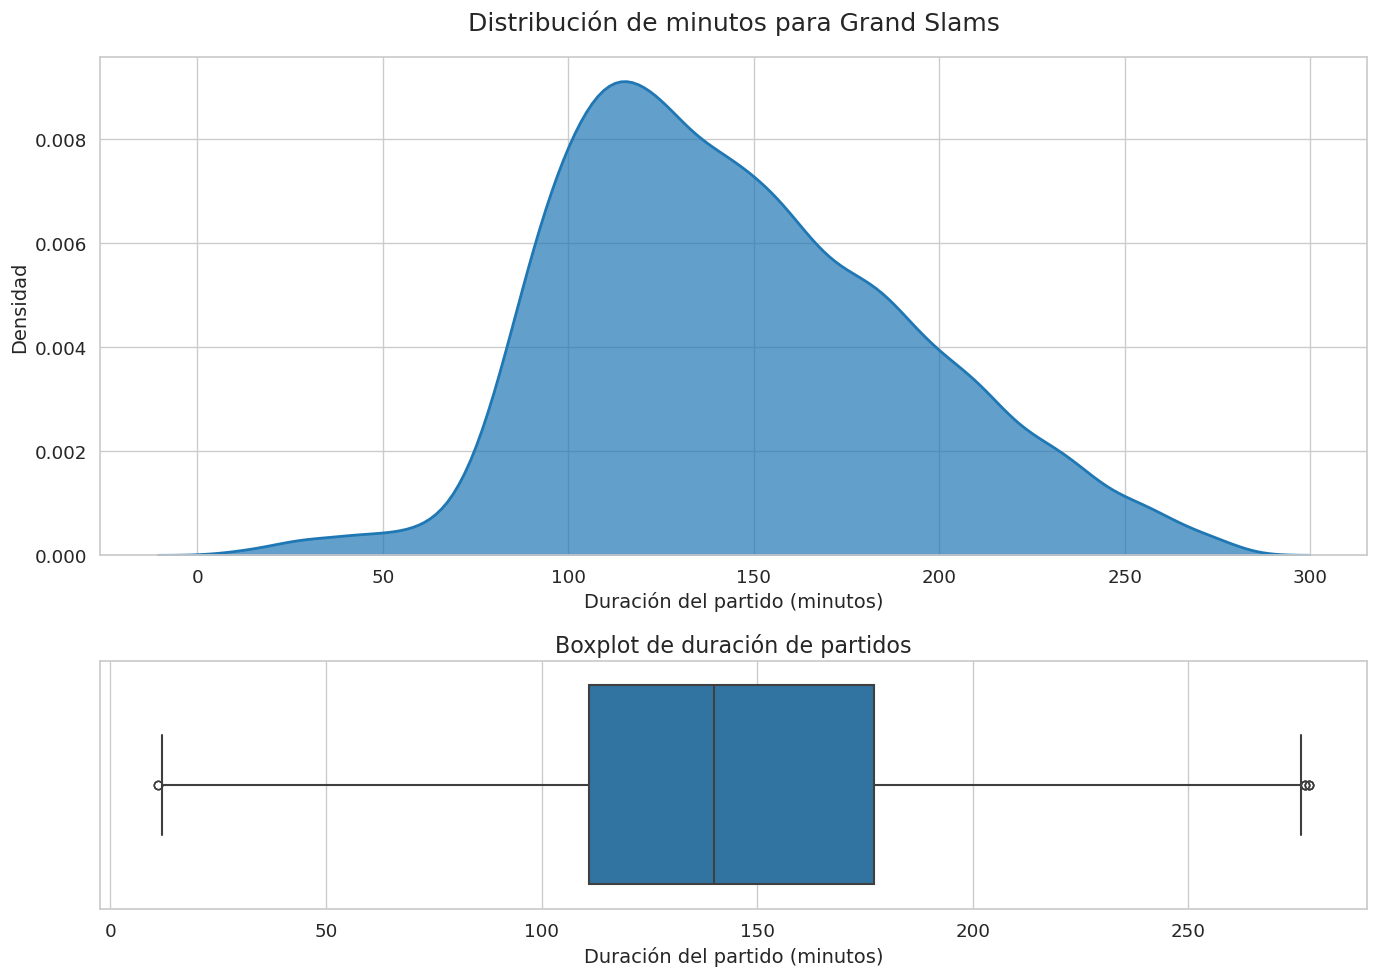

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.2)

# === KDE and Box Plot side-by-side ===
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 10), gridspec_kw={'height_ratios': [2, 1]})

# === KDE Plot ===
sns.kdeplot(
    data=best_of_five, 
    x="minutes", 
    fill=True, 
    color="#1f77b4", 
    linewidth=2, 
    alpha=0.7, 
    ax=axes[0]
)
axes[0].set_title("Distribución de minutos para Grand Slams", fontsize=18, pad=20)
axes[0].set_xlabel("Duración del partido (minutos)", fontsize=14)
axes[0].set_ylabel("Densidad", fontsize=14)

# === Box Plot ===
sns.boxplot(
    data=best_of_five, 
    x="minutes", 
    color="#1f77b4", 
    linewidth=1.5, 
    ax=axes[1]
)
axes[1].set_xlabel("Duración del partido (minutos)", fontsize=14)
axes[1].set_title("Boxplot de duración de partidos", fontsize=16)

plt.tight_layout()
plt.show()


                            OLS Regression Results                            
Dep. Variable:                minutes   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     48.58
Date:                Tue, 20 May 2025   Prob (F-statistic):          7.24e-114
Time:                        22:03:50   Log-Likelihood:                -56170.
No. Observations:               10746   AIC:                         1.124e+05
Df Residuals:                   10733   BIC:                         1.125e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                114.0512     20

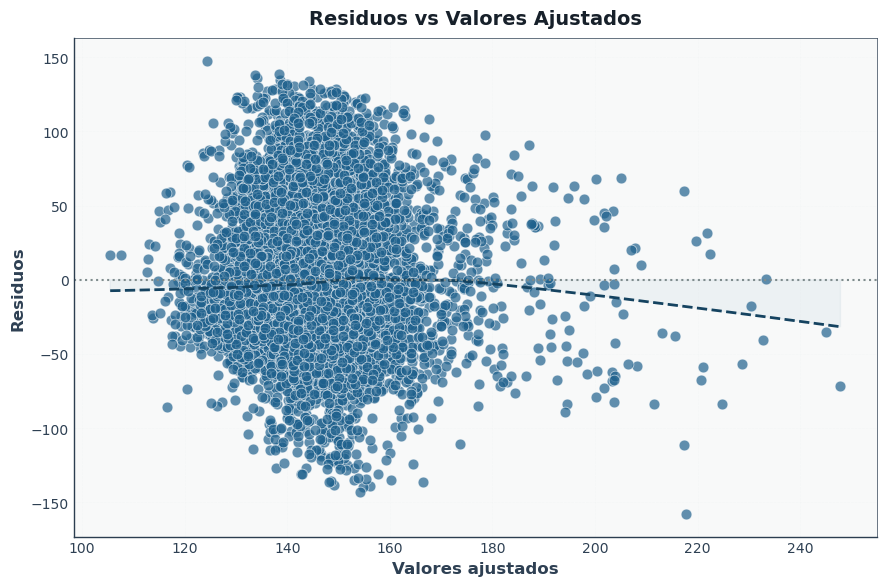

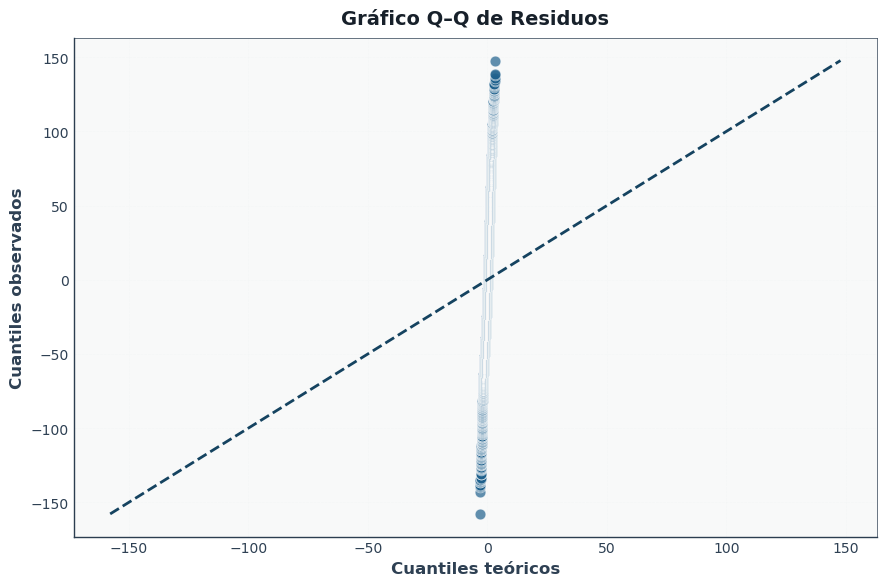

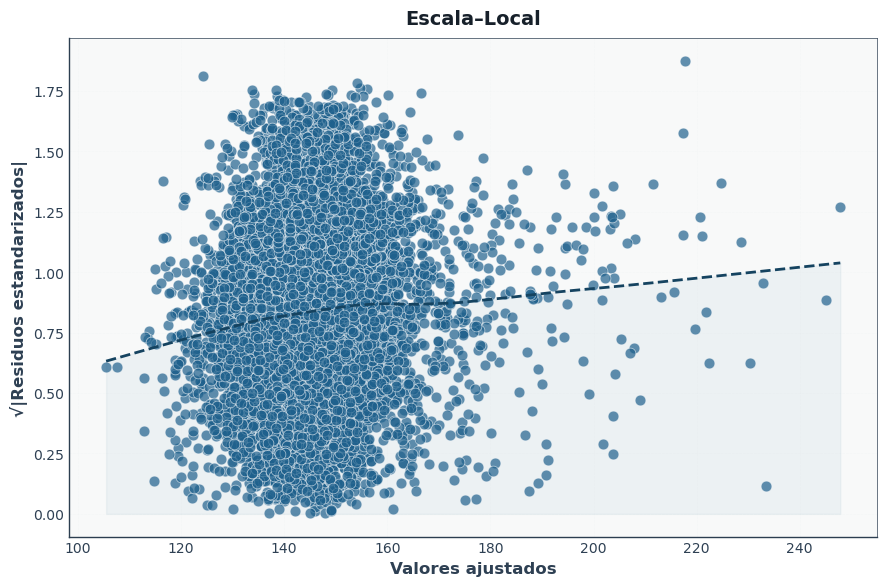

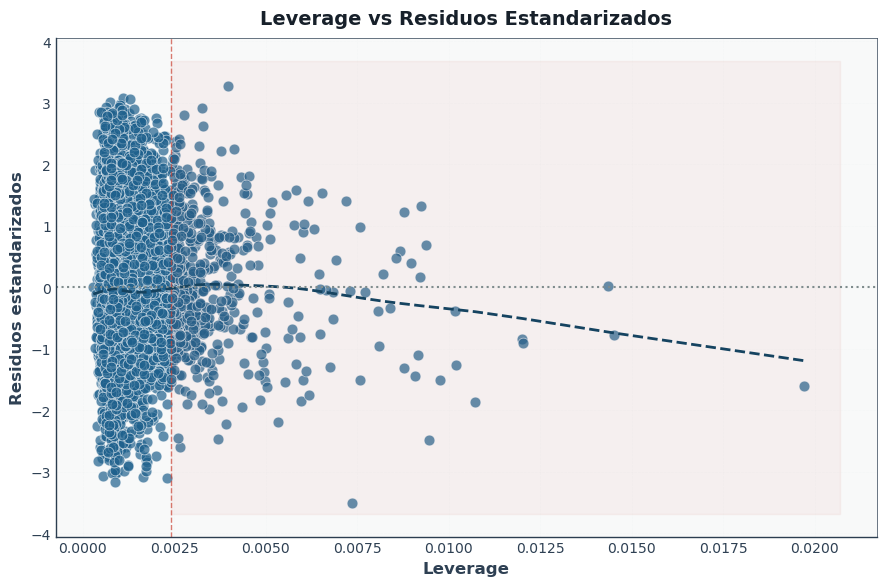

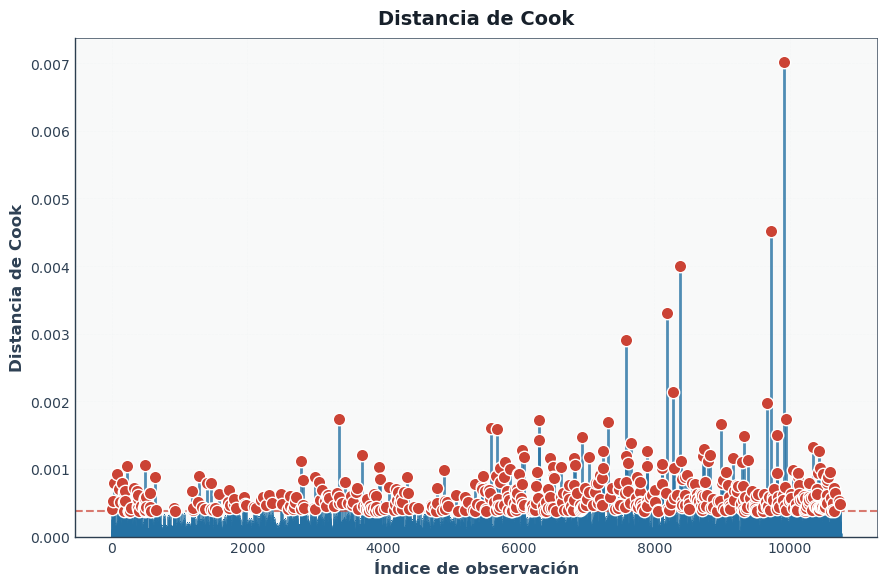

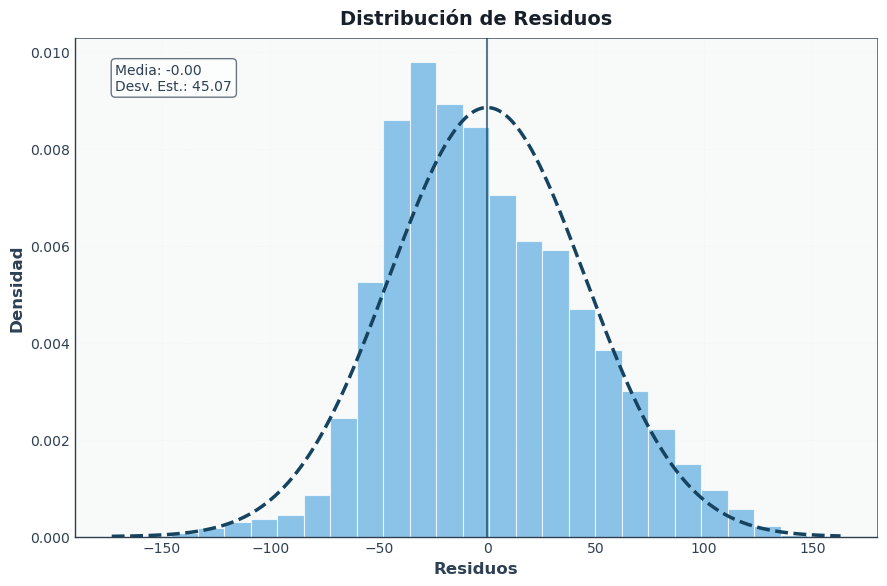

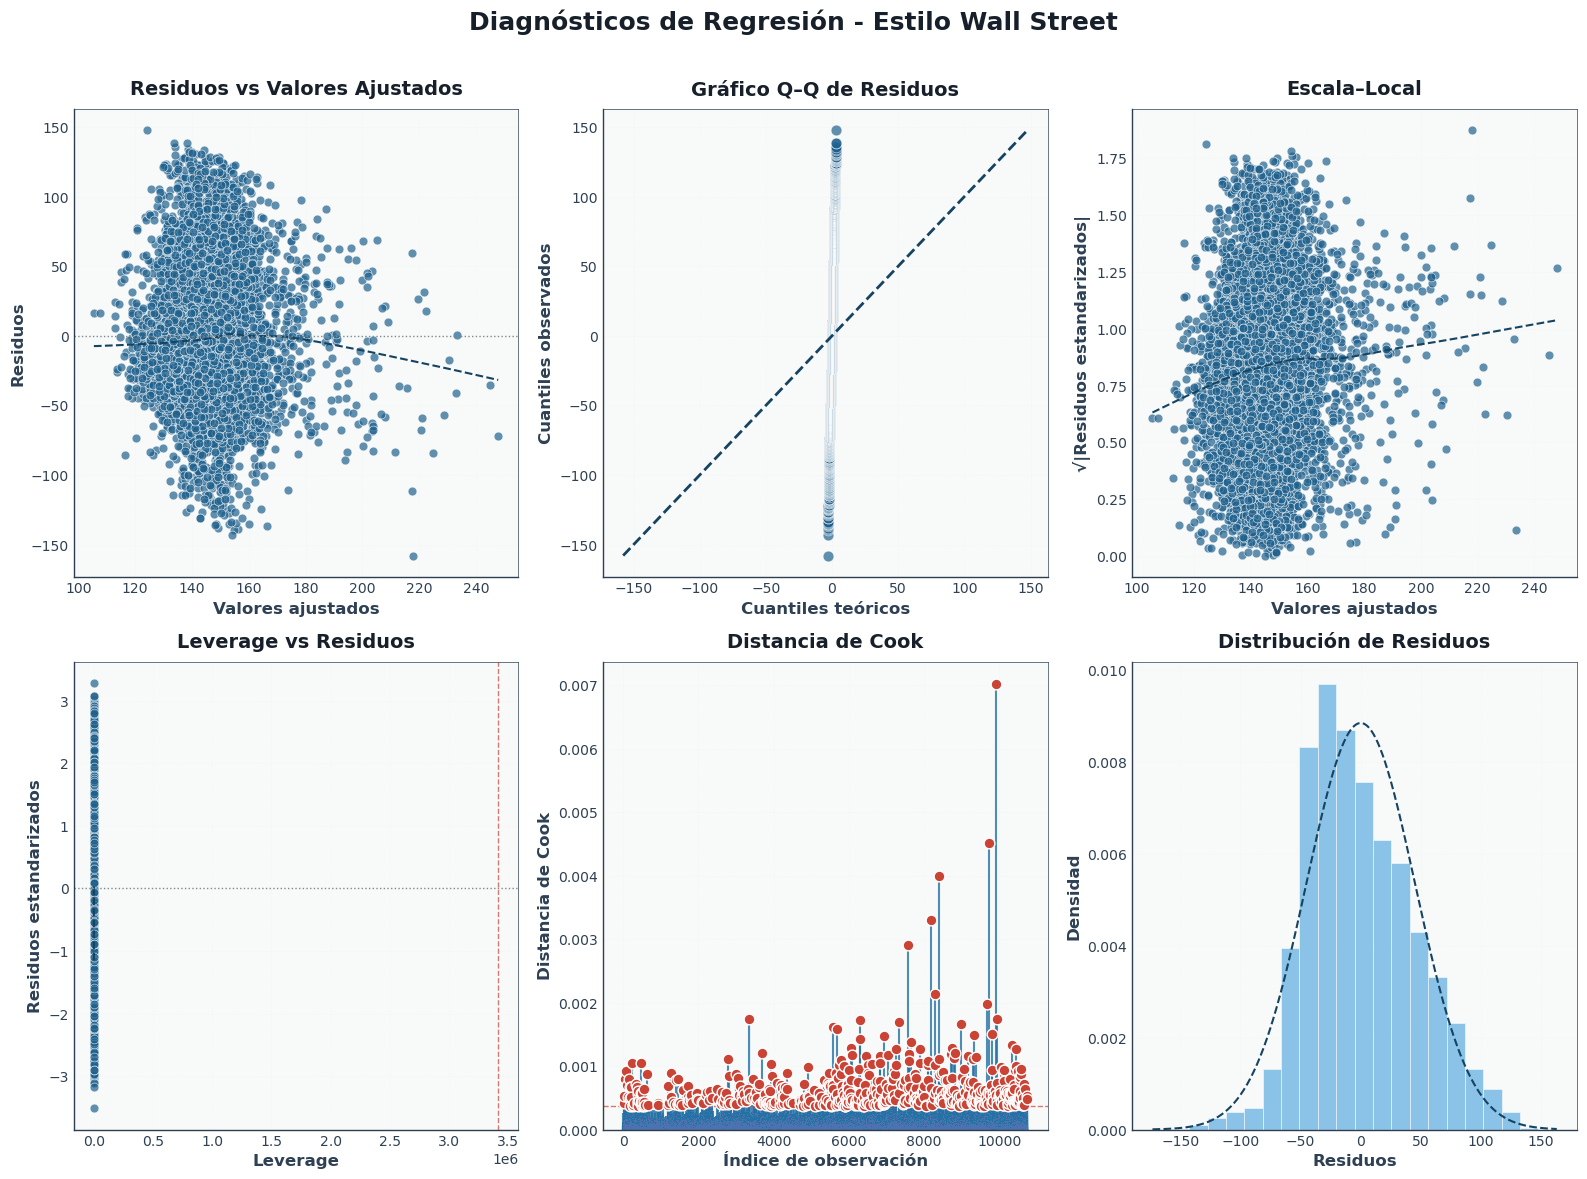

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor, OLSInfluence
from scipy import stats
import matplotlib as mpl
from matplotlib.gridspec import GridSpec

# === Configuración de estilo "Wall Street" mejorado ===
plt.style.use('seaborn-v0_8-whitegrid')  # Base estilo seaborn como punto de partida

# Configuración de fuentes más profesionales - usando fuentes genéricas disponibles en todos los sistemas
plt.rcParams.update({
    'font.family': 'sans-serif',  # Cambiado de 'serif' a 'sans-serif' que está más disponible
    'font.sans-serif': ['Arial', 'DejaVu Sans', 'Liberation Sans', 'Bitstream Vera Sans', 'sans-serif'],
    'font.size': 11,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 16,
    'figure.dpi': 100,
    'figure.figsize': (8, 5),
    'axes.facecolor': 'white',
    'axes.edgecolor': '#2E4053',
    'axes.labelcolor': '#2E4053',
    'axes.grid': True,
    'grid.color': '#ECF0F1',
    'grid.linestyle': '--',
    'grid.linewidth': 0.5,
    'xtick.color': '#2E4053',
    'ytick.color': '#2E4053',
    'text.color': '#2E4053',
    'figure.facecolor': 'white',
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.1
})

# Paleta de azules para estilo financiero/Wall Street
col = {
    'puntos': '#1F618D',       # Azul oscuro para puntos
    'puntos_alpha': 0.7,       # Transparencia
    'lowess': '#154360',       # Azul más oscuro para líneas de tendencia
    'hist': '#5DADE2',         # Azul medio para histogramas
    'stem': '#2471A3',         # Azul intenso para gráficos de tallo
    'linea_cero': '#7F8C8D',   # Gris para líneas de referencia
    'titulo': '#17202A',       # Casi negro para títulos
    'grid': '#ECF0F1',         # Gris muy claro para cuadrículas
    'borde': '#2C3E50',        # Azul oscuro para bordes
    'fondo_panel': '#F8F9F9'   # Gris muy claro para fondo de paneles
}

# Estilo común para todos los gráficos
def estilo_comun(ax, titulo):
    """Aplica estilo común a todos los gráficos"""
    ax.set_facecolor(col['fondo_panel'])
    ax.spines['bottom'].set_color(col['borde'])
    ax.spines['left'].set_color(col['borde'])
    ax.spines['top'].set_color(col['borde'])
    ax.spines['right'].set_color(col['borde'])
    ax.spines['top'].set_linewidth(0.5)
    ax.spines['right'].set_linewidth(0.5)
    ax.spines['bottom'].set_linewidth(1.0)
    ax.spines['left'].set_linewidth(1.0)
    ax.tick_params(axis='both', which='major', direction='in', length=5)
    ax.grid(True, alpha=0.3)
    ax.set_title(titulo, fontweight='bold', color=col['titulo'], pad=10)

# === Paso 1: Preparar datos y ajustar modelo OLS ===
df = best_of_five.copy()
y = df['minutes']
X = df.drop(columns=['minutes'])
X_const = sm.add_constant(X)
model = sm.OLS(y, X_const).fit()

# === Paso 2: Resumen + Durbin–Watson ===
print(model.summary())
print(f"Durbin–Watson: {sms.durbin_watson(model.resid):.3f}")

# === Paso 3: Cálculos diagnósticos ===
fitted = model.fittedvalues
resid = model.resid
std_resid = model.get_influence().resid_studentized_internal
leverage = model.get_influence().hat_matrix_diag
influencia = OLSInfluence(model)
# Convertir a array de NumPy para evitar problemas de indexación
cooks = np.array(influencia.cooks_distance[0])

# === Paso 4: VIF ===
vif = pd.DataFrame({
    'Variable': X_const.columns,
    'VIF': [variance_inflation_factor(X_const.values, i)
            for i in range(X_const.shape[1])]
})
print("\nFactores de Inflación de Varianza:")
print(vif.round(2))

# === Paso 5: Gráficos diagnósticos mejorados ===

# 1. Residuos vs Ajustados
plt.figure(figsize=(9, 6))
ax = plt.subplot(111)
scatter = ax.scatter(fitted, resid, alpha=col['puntos_alpha'], color=col['puntos'], 
                    s=60, edgecolor='white', linewidth=0.5)
low = sm.nonparametric.lowess(resid, fitted)
ax.plot(low[:,0], low[:,1], color=col['lowess'], linestyle='--', linewidth=2)
ax.axhline(0, color=col['linea_cero'], linestyle=':', linewidth=1.5)
ax.set_xlabel("Valores ajustados", fontweight='bold')
ax.set_ylabel("Residuos", fontweight='bold')
estilo_comun(ax, "Residuos vs Valores Ajustados")

# Añadir efecto de sombreado para destacar
ax.fill_between(low[:,0], low[:,1], 0, where=low[:,1]>0, 
                interpolate=True, color=col['puntos'], alpha=0.05)
ax.fill_between(low[:,0], low[:,1], 0, where=low[:,1]<0, 
                interpolate=True, color=col['puntos'], alpha=0.05)

plt.tight_layout()
plt.show()

# 2. Q–Q Plot de residuos mejorado
plt.figure(figsize=(9, 6))
ax = plt.subplot(111)
# Uso una función personalizada en lugar de sm.qqplot para más control sobre el estilo
def qqplot_custom(data, ax):
    q_theoretical = np.linspace(0.001, 0.999, len(data))
    y = np.sort(data)
    x = stats.norm.ppf(q_theoretical, loc=0, scale=1)
    ax.scatter(x, y, alpha=col['puntos_alpha'], color=col['puntos'], 
              s=60, edgecolor='white', linewidth=0.5)
    
    # Línea de 45 grados
    min_val = min(np.min(x), np.min(y))
    max_val = max(np.max(x), np.max(y))
    ax.plot([min_val, max_val], [min_val, max_val], color=col['lowess'], 
            linestyle='--', linewidth=2)
    
    return ax

qqplot_custom(resid, ax)
ax.set_xlabel("Cuantiles teóricos", fontweight='bold')
ax.set_ylabel("Cuantiles observados", fontweight='bold')
estilo_comun(ax, "Gráfico Q–Q de Residuos")
plt.tight_layout()
plt.show()

# 3. Escala–Local (√|residuo estandarizado|)
plt.figure(figsize=(9, 6))
ax = plt.subplot(111)
scatter = ax.scatter(fitted, np.sqrt(np.abs(std_resid)), 
                    alpha=col['puntos_alpha'], color=col['puntos'], 
                    s=60, edgecolor='white', linewidth=0.5)
low2 = sm.nonparametric.lowess(np.sqrt(np.abs(std_resid)), fitted)
ax.plot(low2[:,0], low2[:,1], color=col['lowess'], linestyle='--', linewidth=2)
ax.set_xlabel("Valores ajustados", fontweight='bold')
ax.set_ylabel("√|Residuos estandarizados|", fontweight='bold')
estilo_comun(ax, "Escala–Local")

# Añadir efecto de sombreado para destacar tendencia
ax.fill_between(low2[:,0], low2[:,1], 0, 
                interpolate=True, color=col['puntos'], alpha=0.05)

plt.tight_layout()
plt.show()

# 4. Leverage vs Residuos estandarizados
plt.figure(figsize=(9, 6))
ax = plt.subplot(111)
scatter = ax.scatter(leverage, std_resid, 
                    alpha=col['puntos_alpha'], color=col['puntos'], 
                    s=60, edgecolor='white', linewidth=0.5)
low3 = sm.nonparametric.lowess(std_resid, leverage)
ax.plot(low3[:,0], low3[:,1], color=col['lowess'], linestyle='--', linewidth=2)
ax.axhline(0, color=col['linea_cero'], linestyle=':', linewidth=1.5)

# Añadir líneas de referencia para leverage alto
# Calcular un umbral de leverage (común es 2*(p+1)/n donde p es número de predictores y n es tamaño de muestra)
p = len(X.columns)
n = len(X)
umbral_leverage = 2 * (p + 1) / n

# Asegurarse de que umbral_leverage es un escalar
if isinstance(umbral_leverage, (list, np.ndarray)):
    umbral_leverage = float(umbral_leverage[0])

# Añadir la línea vertical para el umbral
ax.axvline(umbral_leverage, color='#CB4335', linestyle='--', linewidth=1, alpha=0.7)

ax.set_xlabel("Leverage", fontweight='bold')
ax.set_ylabel("Residuos estandarizados", fontweight='bold')
estilo_comun(ax, "Leverage vs Residuos Estandarizados")

# Añadir sombreado para destacar observaciones potencialmente influyentes
ax.fill_between([umbral_leverage, max(leverage)*1.05], 
                [-max(abs(std_resid))*1.05, -max(abs(std_resid))*1.05], 
                [max(abs(std_resid))*1.05, max(abs(std_resid))*1.05], 
                color='#CB4335', alpha=0.05)

plt.tight_layout()
plt.show()

# 5. Distancia de Cook con diseño mejorado
plt.figure(figsize=(9, 6))
ax = plt.subplot(111)

# Crear una base sombreada para el gráfico
ax.bar(np.arange(len(cooks)), cooks, color=col['hist'], alpha=0.3, width=0.8)

# Líneas de tallo para destacar cada punto
markerline, stemlines, baseline = ax.stem(np.arange(len(cooks)), cooks, markerfmt=",", basefmt=" ")
plt.setp(stemlines, 'color', col['stem'], 'linewidth', 2, 'alpha', 0.8)
plt.setp(markerline, 'color', col['stem'], 'markersize', 6)

# Añadir línea de umbral para puntos influyentes (común es 4/n)
umbral_cook = 4/len(cooks)
ax.axhline(umbral_cook, color='#CB4335', linestyle='--', linewidth=1.5, alpha=0.7)

# Identificar puntos influyentes - corregido para trabajar con array NumPy
puntos_influyentes = np.where(cooks > umbral_cook)[0]
if len(puntos_influyentes) > 0:
    # Ahora podemos indexar directamente el array NumPy
    ax.scatter(puntos_influyentes, cooks[puntos_influyentes], 
               color='#CB4335', s=80, zorder=3, edgecolor='white')

ax.set_xlabel("Índice de observación", fontweight='bold')
ax.set_ylabel("Distancia de Cook", fontweight='bold')
estilo_comun(ax, "Distancia de Cook")
plt.tight_layout()
plt.show()

# 6. Histograma de residuos con curva normal mejorado
plt.figure(figsize=(9, 6))
ax = plt.subplot(111)

# Histograma con más estilo
n, bins, patches = ax.hist(resid, bins=25, density=True, alpha=0.7, color=col['hist'], 
                           edgecolor='white', linewidth=0.8)

# Mejorar la curva normal
xmin, xmax = ax.get_xlim()
x = np.linspace(xmin, xmax, 1000)
y = stats.norm.pdf(x, loc=resid.mean(), scale=resid.std())
ax.plot(x, y, linestyle='--', color=col['lowess'], linewidth=2.5)

# Añadir línea vertical para la media
ax.axvline(resid.mean(), color=col['lowess'], linestyle='-', linewidth=1.5, alpha=0.7)

ax.set_xlabel("Residuos", fontweight='bold')
ax.set_ylabel("Densidad", fontweight='bold')
estilo_comun(ax, "Distribución de Residuos")

# Añadir estadísticas en el gráfico
textstr = f'Media: {resid.mean():.2f}\nDesv. Est.: {resid.std():.2f}'
props = dict(boxstyle='round', facecolor='white', alpha=0.7, edgecolor=col['borde'])
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

# === BONUS: Gráfico combinado en panel único ===
# Crear un panel único con todos los gráficos de diagnóstico para una presentación profesional
plt.figure(figsize=(16, 12))
gs = GridSpec(2, 3, figure=plt.gcf())

# 1. Residuos vs Ajustados
ax1 = plt.subplot(gs[0, 0])
ax1.scatter(fitted, resid, alpha=col['puntos_alpha'], color=col['puntos'], 
           s=40, edgecolor='white', linewidth=0.5)
low = sm.nonparametric.lowess(resid, fitted)
ax1.plot(low[:,0], low[:,1], color=col['lowess'], linestyle='--', linewidth=1.5)
ax1.axhline(0, color=col['linea_cero'], linestyle=':', linewidth=1)
ax1.set_xlabel("Valores ajustados", fontweight='bold')
ax1.set_ylabel("Residuos", fontweight='bold')
estilo_comun(ax1, "Residuos vs Valores Ajustados")

# 2. Q–Q Plot de residuos
ax2 = plt.subplot(gs[0, 1])
qqplot_custom(resid, ax2)
ax2.set_xlabel("Cuantiles teóricos", fontweight='bold')
ax2.set_ylabel("Cuantiles observados", fontweight='bold')
estilo_comun(ax2, "Gráfico Q–Q de Residuos")

# 3. Escala–Local
ax3 = plt.subplot(gs[0, 2])
ax3.scatter(fitted, np.sqrt(np.abs(std_resid)), 
           alpha=col['puntos_alpha'], color=col['puntos'], 
           s=40, edgecolor='white', linewidth=0.5)
low2 = sm.nonparametric.lowess(np.sqrt(np.abs(std_resid)), fitted)
ax3.plot(low2[:,0], low2[:,1], color=col['lowess'], linestyle='--', linewidth=1.5)
ax3.set_xlabel("Valores ajustados", fontweight='bold')
ax3.set_ylabel("√|Residuos estandarizados|", fontweight='bold')
estilo_comun(ax3, "Escala–Local")

# 4. Leverage vs Residuos estandarizados
ax4 = plt.subplot(gs[1, 0])
ax4.scatter(leverage, std_resid, 
           alpha=col['puntos_alpha'], color=col['puntos'], 
           s=40, edgecolor='white', linewidth=0.5)
low3 = sm.nonparametric.lowess(std_resid, leverage)
ax4.plot(low3[:,0], low3[:,1], color=col['lowess'], linestyle='--', linewidth=1.5)
ax4.axhline(0, color=col['linea_cero'], linestyle=':', linewidth=1)

# Calcular umbral de leverage y asegurarse de que sea un escalar
umbral_leverage = 2 * (p + 1) / n
if isinstance(umbral_leverage, (list, np.ndarray)):
    umbral_leverage = float(umbral_leverage[0])

# Añadir la línea vertical para el umbral
ax4.axvline(umbral_leverage, color='#CB4335', linestyle='--', linewidth=1, alpha=0.7)

ax4.set_xlabel("Leverage", fontweight='bold')
ax4.set_ylabel("Residuos estandarizados", fontweight='bold')
estilo_comun(ax4, "Leverage vs Residuos")

# 5. Distancia de Cook
ax5 = plt.subplot(gs[1, 1])
ax5.bar(np.arange(len(cooks)), cooks, color=col['hist'], alpha=0.3, width=0.8)
markerline, stemlines, baseline = ax5.stem(np.arange(len(cooks)), cooks, markerfmt=",", basefmt=" ")
plt.setp(stemlines, 'color', col['stem'], 'linewidth', 1.5, 'alpha', 0.8)
umbral_cook = 4/len(cooks)
ax5.axhline(umbral_cook, color='#CB4335', linestyle='--', linewidth=1, alpha=0.7)

# Identificar puntos influyentes - corregido para trabajar con array NumPy
puntos_influyentes = np.where(cooks > umbral_cook)[0]
if len(puntos_influyentes) > 0:
    # Ahora podemos indexar directamente el array NumPy
    ax5.scatter(puntos_influyentes, cooks[puntos_influyentes], 
               color='#CB4335', s=60, zorder=3, edgecolor='white')

ax5.set_xlabel("Índice de observación", fontweight='bold')
ax5.set_ylabel("Distancia de Cook", fontweight='bold')
estilo_comun(ax5, "Distancia de Cook")

# 6. Histograma de residuos
ax6 = plt.subplot(gs[1, 2])
n, bins, patches = ax6.hist(resid, bins=20, density=True, alpha=0.7, color=col['hist'], 
                           edgecolor='white', linewidth=0.5)
xmin, xmax = ax6.get_xlim()
x = np.linspace(xmin, xmax, 500)
y = stats.norm.pdf(x, loc=resid.mean(), scale=resid.std())
ax6.plot(x, y, linestyle='--', color=col['lowess'], linewidth=1.5)
ax6.set_xlabel("Residuos", fontweight='bold')
ax6.set_ylabel("Densidad", fontweight='bold')
estilo_comun(ax6, "Distribución de Residuos")

plt.suptitle("Diagnósticos de Regresión - Estilo Wall Street", 
             fontsize=18, fontweight='bold', color=col['titulo'], y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()